In [1]:
import shutil

import matplotlib.pyplot as plt
import pingouin as pg
import numpy as np
import pandas as pd
from fsspec.implementations.local import LocalFileSystem

from dummy_baskets import generate_dummy_baskets, run_index_basket_upload_test
from weave.index.index_pandas import IndexPandas
from weave.index.index_sqlite import IndexSQLite
from weave.index.index_sql import IndexSQL
from weave import Pantry

In this notebok we will run 5 upload tests on each index backend (IndexPandas, IndexSQLite, IndexSQL) and compare the average upload time. We will be using 1000 baskets, 10 upload files, 1 MB file size, and 5 basket types as the parameters in each test. Statistical tests will be performed across the three different index backends to determine if there is a statistical significant difference in upload time between all the index backends.

Index Pandas Tests

In [2]:
pandas_times = []
baskets = generate_dummy_baskets(basket_count=1000, file_count=10, file_size_mb=1, file_path="dummy_txt", num_basket_types=5)

for _ in range(5):
    pantry_pandas = Pantry(IndexPandas, pantry_path="dummy_pantry", file_system=LocalFileSystem())
    time = run_index_basket_upload_test(basket_list=baskets, pantry=pantry_pandas)
    pandas_times.append(time)
    shutil.rmtree("dummy_pantry")

shutil.rmtree("dummy_txt")

print(f"Pandas index upload times: {pandas_times}")
print(f"Average pandas index upload time for 5 different tests: {np.mean(pandas_times)}")

Pandas index upload times: [175.7241928577423, 166.37030243873596, 178.7772114276886, 174.15989565849304, 173.84066104888916]
Average pandas index upload time for 5 different tests: 173.77445268630981


Index SQLite Tests

In [3]:
sqlite_times = []
baskets = generate_dummy_baskets(basket_count=1000, file_count=10, file_size_mb=1, file_path="dummy_txt", num_basket_types=5)

for _ in range(5):
    pantry_sqlite = Pantry(IndexSQLite, pantry_path="dummy_pantry", file_system=LocalFileSystem())
    time = run_index_basket_upload_test(basket_list=baskets, pantry=pantry_sqlite)
    sqlite_times.append(time)
    shutil.rmtree("dummy_pantry")
    pantry_sqlite.index.drop_index()

shutil.rmtree("dummy_txt")

print(f"SQLite index upload times: {sqlite_times}")
print(f"Average SQLite index upload time for 5 different tests: {np.mean(sqlite_times)}")

SQLite index upload times: [47.1196563243866, 46.50678610801697, 47.11011600494385, 47.36418128013611, 45.54590201377869]
Average SQLite index upload time for 5 different tests: 46.729328346252444


Index SQL Tests

In [4]:
sql_times = []
baskets = generate_dummy_baskets(basket_count=1000, file_count=10, file_size_mb=1, file_path="dummy_txt", num_basket_types=5)

for _ in range(5):
    pantry_sql = Pantry(IndexSQL, pantry_path="dummy_pantry", file_system=LocalFileSystem())
    time = run_index_basket_upload_test(basket_list=baskets, pantry=pantry_sql)
    sql_times.append(time)
    shutil.rmtree("dummy_pantry")
    pantry_sql.index.drop_index()

shutil.rmtree("dummy_txt")

print(f"SQL index upload times: {sql_times}")
print(f"Average SQL index upload time for 5 different tests: {np.mean(sql_times)}")

SQL index upload times: [33.44623064994812, 46.75321841239929, 44.79952788352966, 32.022818088531494, 36.288578271865845]
Average SQL index upload time for 5 different tests: 38.662074661254884


Performance Difference Between all 3 Index Backends

In [5]:
index_times_df = pd.DataFrame({
    "Pandas Index": pandas_times,
    "SQLite Index": sqlite_times,
    "SQL Index": sql_times
})
index_times_df

,Pandas Index,SQLite Index,SQL Index
0,175.724193,47.119656,33.446231
1,166.370302,46.506786,46.753218
2,178.777211,47.110116,44.799528
3,174.159896,47.364181,32.022818
4,173.840661,45.545902,36.288578


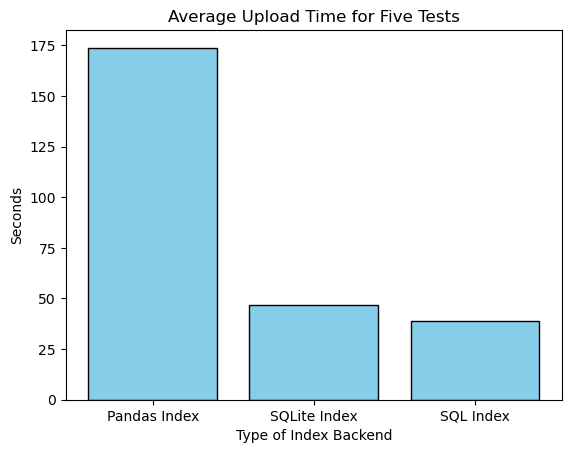

In [6]:
categories = ["Pandas Index", "SQLite Index", "SQL Index"]
values = [np.mean(pandas_times), np.mean(sqlite_times), np.mean(sql_times)]

plt.bar(categories, values, color='skyblue', edgecolor='black')

plt.xlabel('Type of Index Backend')
plt.ylabel('Seconds')
plt.title('Average Upload Time for Five Tests')

plt.show()

In [7]:
all_times = pandas_times + sqlite_times + sql_times

times_df = pd.DataFrame({
    "Index": ["Pandas"] * 5 + ["SQLite"] * 5 + ["SQL"] * 5,
    "Upload_Time": all_times
})

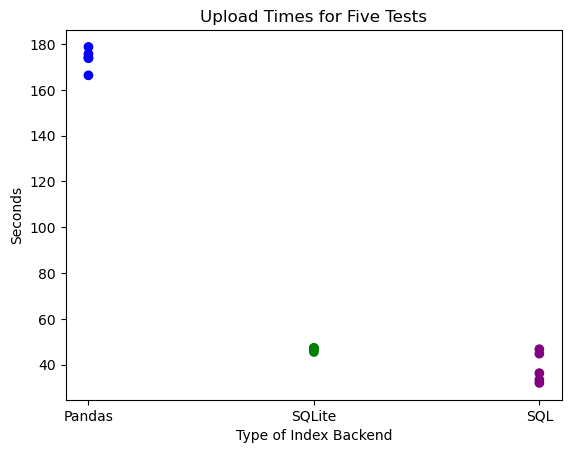

In [8]:
color_map = {"Pandas": "blue", "SQLite": "green", "SQL": "purple"}
colors = times_df['Index'].map(color_map)

plt.scatter(times_df['Index'], times_df['Upload_Time'], c=colors)

plt.xlabel('Type of Index Backend')
plt.ylabel('Seconds')
plt.title('Upload Times for Five Tests')

plt.show()

ANOVA Test Between the Three Index Backends

In [9]:
pg.anova(data=times_df, dv='Upload_Time', between='Index')

,Source,ddof1,ddof2,F,p-unc,np2
0,Index,2,12,1295.488083,9.599892e-15,0.99539


Since we have a p-value of less than 0.05 we can say that the average upload times between index backends are statistically different.
Now we can perform a post-hoc analysis to determine which specific index upload times are statistically different between each other.

In [10]:
times_df.pairwise_tukey(dv='Upload_Time', between='Index').round(3)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Pandas,SQL,173.774,38.662,135.112,2.978,45.374,0.000,21.250
1,Pandas,SQLite,173.774,46.729,127.045,2.978,42.665,0.000,35.008
2,SQL,SQLite,38.662,46.729,-8.067,2.978,-2.709,0.046,-1.527


Since each p-value in the post-hoc analysis is less than 0.05, we can determine that there is a statistically significant difference between each index upload time.

Indexes Ranked by Upload Time:
1. SQL
2. SQLite
3. Pandas